# Traffic Sign Recognition System

![image](./imgs/GTSRB.jpg)

This notebook presents the development process of a TensorFlow model that classifies traffic signs with accuracy 99%, using German Traffic Sign Recognition (GTSR) dataset.   
You can Download the data from [HERE](https://drive.google.com/drive/folders/1WzPw3V9bYl0rC86ATm7zR0rbwYloDDzN)



**NOTE: IF YOU DO NOT HAVE THE DATA FOLDER PLEASE DO NOT RUN THE CELLS**

-------
**Importing Libraries**

In [ ]:
# run this cell to download necessary libraries if not already installed
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install opencv-python

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Input Data

The dataset is in a folder called Images, where each category of signs is in a separate folder called by the sign label.  
```
└── Images
    ├── 0
    |   ├── 00000_00000_00000.png
    |   ├── 00000_00000_00001.png
    |   ..
    |   ..    
    ├── 1
    |   ├── 00001_00000_00000.png
    |   ├── 00001_00000_00001.png
    |   ..
    |   .. 
```

We can benefit from this structure and use `image_dataset_from_directory` tensorflow function to do the trick and read the data properly.  
By investigating the images we can see that the images are in different sizes, and some of them are very dark, these are problems we have to solve before building the model.  
We can resize all the images to be 32 in width, 32 in height, and for different lightness values of the images, it would be better to transform the images from rgb color space to gray scale color space.  
One more problem we could face is the huge amount of training data set, if we trained the model without batching the dataset then this will slow the training process, that's why we usually have to partition our data set into batches of the same size, and this value of batch size is actually a hyperparamter, and I will use 64 as a batch size.  

There is a csv file contains the mapping between the labels and the meaning of each one, it would be nice if we map each sign label to the real meaning so we can interpret them nicely  

In [3]:
BATCH_SIZE = 64
# read the data from the directory
dataset = tf.keras.preprocessing.image_dataset_from_directory('./Images', batch_size=BATCH_SIZE, color_mode='grayscale', image_size=(32,32))
# get class names
class_names = dataset.class_names
# get labels meaning 
labels_meaning = pd.read_csv('labels_mapping.csv')

Found 39211 files belonging to 43 classes.


To make sure the data is read properly let's visualize 9 images from the dataset with their labels and compare them to the actual labels.  
Each time you run the cell different images are displayed, so run it more than one time to be more sure that the data is properly read

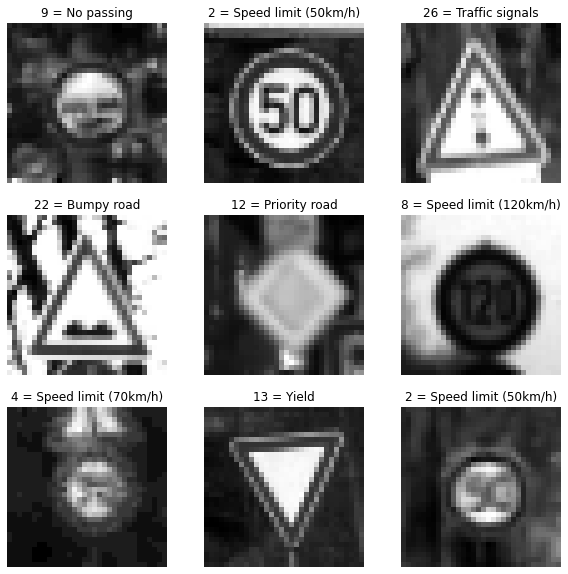

In [4]:
plt.figure(figsize=(10,10))
# get images from first batch
for images, labels in dataset.take(1):
    # draw only 9
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        sign_label = class_names[labels[i]] 
        plt.title(sign_label + " = {}".format(labels_meaning.iloc[int(sign_label)].meaning))
        # don't show axis
        plt.axis("off")

### Train, Val, Test split

In all machine learning problems we need to train the model on a subset of our data and use the rest to test the model performance.  
We will split the data into three sub-sets `Training set`, `Testing set`, `Validation set` with ratios `0.7`, `0.1`, `0.2` respectively.  
`Training set` is used for training the model, `Validation set` is used to evaluate the model to update the weights during training, while `Testing set` should only be used at the final stage to test the model efficiency.

In [5]:
# get the size of the whole dataset
ds_size  = tf.data.experimental.cardinality(dataset).numpy()

# calculate the size of each set
train_size = int(0.6 * ds_size)
test_size = int(0.2 * ds_size)
val_size = ds_size - train_size - test_size

# shuffle the dataset before splitting
dataset = dataset.shuffle(ds_size, seed=42, reshuffle_each_iteration=False)

# splitting the dataset into the three sub-sets
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(test_size)
test_ds = dataset.skip(train_size).skip(test_size)

### Model Building
Next is to build our model which we will wrap in a class for abstraction.  

In [6]:
def read_img(path):
    img = cv.imread(path, 0)
    if img is None:
        print("Invalid path")
        return
    img = cv.resize(img, (32, 32)).reshape((32, 32, 1))
    img_tensor = tf.expand_dims(img, 0)
    return img_tensor
    
    
    
class Model:
    def __init__(self):
        new = False
        try:
            self.load_model('./model/my_model.h5')
        except:
            new = True
            self.history = None

        
        if new:
            self.model = tf.keras.Sequential([
                # normalize the image pixels value to help the model converge fast
                layers.experimental.preprocessing.Rescaling(1./255, input_shape=(32, 32, 1)),

                layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),

                layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),

                layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),

                layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),

                layers.Flatten(),
                layers.Dense(1000, activation='relu'),
                layers.Dense(250, activation='relu'),
                layers.Dropout(.2),
                
                # output layer
                layers.Dense(43, activation='softmax')
            ])
        
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        
    def load_model(self, model_path):
        """ This function load the pre-compiled model given its path and set the class instance model with it """
        loaded_model = tf.keras.models.load_model(model_path)
        self.history = np.load('./model/model_history.npy', allow_pickle=True).item()
        self.model = loaded_model
        
        
    def train(self, train_dataset=None, val_dataset=None, epochs=10):
        """ This function trains the model on the provided training set while using the provided validation set for tuning it """
        
        if train_dataset is None or val_dataset is None:
            print("Empty datasets")
            return
        
        try:
            history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
            np.save('./model/model_history.npy', history.history)
            self.history = history.history
        except Exception as e:
            print("An error occurred during training.")
            print(e)
            return
      
    
    def evaluate(self, test_dataset):
        """ This function evaluates the model against the provided test set and returns loss, accuracy on successful testing"""
        try:
            return self.model.evaluate(test_dataset)
        except Exception as e:
            print("An error occurred during evaluation.")
            print(e)
    
        
    def predict(self, img):
        """
        This function is using in the deployment phase
        
        Input:
        ======
            img: numpy array representing the image [in grayscale or rgb mode]
        
        Output:
        =======
            string represents the predicted label of the passed image
        """
        # predict the label of the image
        probs = self.model.predict(img)
        
        # return the label, which is the index of the maximum predicted propability 
        return class_names[np.argmax(probs)]
        

        
    def save_model(self):
        """ This function save the model to a file, so no need to re-train the model every time"""
        tf.keras.models.save_model(self.model, './model/my_model.h5', save_format='h5')
        
    def visualize_performance(self):
        if self.history is None:
            print("the model is not trained")
            return
        
        fig = plt.figure(figsize=(10,6))
        metrics = ['loss', 'accuracy']
        for i, metric in enumerate(metrics):
            ax = plt.subplot(1, 2, i+1)
            ax.plot(self.history[metric])
            ax.plot(self.history['val_{}'.format(metric)])
            ax.set_xlabel('epoch')
            ax.set_ylabel(metric)
            ax.legend(['training {}'.format(metric), 'validation {}'.format(metric)])
            ax.set_title('Training/Validation {}'.format(metric))
        fig.savefig('performance.jpg')
        plt.show()
        

In [7]:
# create our model
cnn_model = Model()

In [8]:
# have a look at the architecture of our model
cnn_model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0

### Model Training

**`NEXT CELL IS FOR TRAINING THE MODEL, SINCE A .h5 FILE IS READY WITH THE TRAINED MODEL, NO NEED TO RUN THIS CELL`**

In [9]:
#cnn_model.train(train_dataset=train_ds, val_dataset=val_ds, epochs=10)
#cnn_model.save_model()

Epoch 1/10
367/367 [==============================] - 349s 943ms/step - loss: 1.1181 - accuracy: 0.6938 - val_loss: 0.0894 - val_accuracy: 0.9734
Epoch 2/10
367/367 [==============================] - 336s 910ms/step - loss: 0.1011 - accuracy: 0.9715 - val_loss: 0.0570 - val_accuracy: 0.9836
Epoch 3/10
367/367 [==============================] - 340s 922ms/step - loss: 0.0518 - accuracy: 0.9859 - val_loss: 0.0158 - val_accuracy: 0.9967
Epoch 4/10
367/367 [==============================] - 957s 3s/step - loss: 0.0388 - accuracy: 0.9894 - val_loss: 0.0213 - val_accuracy: 0.9935
Epoch 5/10
367/367 [==============================] - 313s 850ms/step - loss: 0.0308 - accuracy: 0.9903 - val_loss: 0.0129 - val_accuracy: 0.9951
Epoch 6/10
367/367 [==============================] - 307s 833ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.0113 - val_accuracy: 0.9963
Epoch 7/10
367/367 [==============================] - 307s 833ms/step - loss: 0.0270 - accuracy: 0.9923 - val_loss: 0.0113 - va

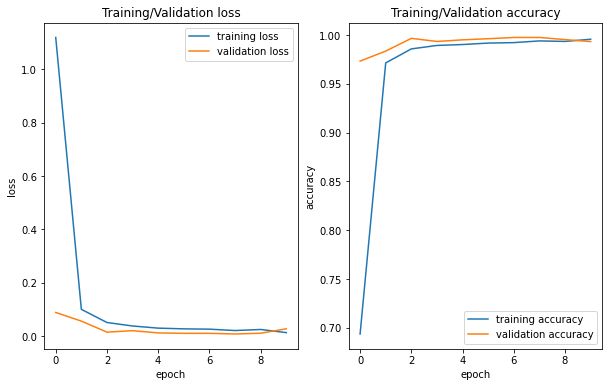

In [9]:
cnn_model.visualize_performance()

By looking at the learning curves above, the model seems to perform quite well  
the learning curve shows a good fit if:
1. The plot of training loss decreases to a point of stability.
2. The plot of validation loss decreases to a point of stability and has a small gap with the training loss.  

which can be seen in the model learning curves above, so we can conclude that our model is quite `GOOD` and doesn't suffer from *underfitting / overfitting*

### Model Evaluation

In [13]:
# Evaluate the model

loss, acc = cnn_model.evaluate(test_ds)
print("")
print("=============================")
print("Testing accuracy is %.2f%% "%(acc*100))
print("=============================")


124/124 [==============================] - 19s 137ms/step - loss: 0.0236 - accuracy: 0.9931

Testing accuracy is 99.31% 


# Inference

In [13]:
# change the variable to be your image path
image_path = './Images/15/00015_00000_00010.png'
# rgb image for plotting
rgb = plt.imread(image_path)
# reading and do necessary preprocessing steps for the image
img = read_img(image_path)

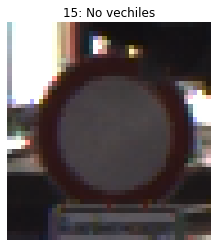

In [14]:
# prediciton
label = cnn_model.predict(img)
plt.imshow(rgb)
plt.title('{}: {}'.format(label, labels_meaning.iloc[int(label)].meaning))
plt.axis('off')
plt.show()